# Normalized Mean Hydrograph

__Description__: Calculates normalized mean hydrographs for the specified USGS Stream Gage and, optionally, creates the final fluvial forcing file.

__Input__: 
- The USGS Gage ID, a discharge threshold value, and filenames and paths.
- The *Sampler_Operation_.xlsx* for the specified USGS Stream Gage, which contains the production list of events. This Excel Workbook is created by the `PM_Sampler_Ops` Jupyter Notebook.
- The *Fluvial_Parameters.xlsx* which contains information on the fluvial model, including its run duration and time step.

__Output__: 

Either

- a *.json* file containing the normalized mean hydrographs grouped by the event duration and the associated metadata needed to reproduce the hydrographs for different recurrence intervals 

or

- the final fluvial forcing and weights *.json*s for for the specified boundary condition.

---

## A. Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydrographs import*
from nb_libraries import*
from fluvial_hydro import*

### Parameters:
#### Site specific:

In [2]:
Project_Area = 'DC'      # Project area name
Fluvial_Model = 'F02'    # Fluvial model name
Domain = 'D01'           # Name of the model domain
BCN = 'F03'              # Boundary condition name
USGS_ID = '01649500'     # USGS station ID

export_forcing = True    # Specify whether you want to save the fluvial forcing (True) or export the normalized mean hydrographs for joint probability (False)
data_threshold = 800     # Q at 1.75 Return Period. This value can be identified from HEC-SSP analysis.

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs/{0}_{1}'.format(Project_Area, Fluvial_Model)
outputs_dir = root_dir/'Outputs'
forcing_dir = outputs_dir/'{0}_{1}_Forcing'.format(Project_Area, Fluvial_Model)
fluvial_params = '{0}_{1}_Fluvial_Parameters.xlsx'.format(Project_Area, Fluvial_Model)

#### Project specific (global):

In [3]:
parameter = "00060"  # USGS discharge code

## Options
timestep = 5              # [minutes]; timestep
int_increment = 20        # Interpolation increment
fluvial_BC_units = 'cfs'  # The fluvial boundary condition units
verbose = True            # Option to display print statements

### Data:
#### Fluvial model parameters:

In [4]:
fm = pd.read_excel(inputs_dir/fluvial_params, sheet_name = 'Fluvial_Model', index_col = 'Fluvial Model')
fm.head(2)

Run Duration (Days)  Timestep (Minutes) Time Index Ordinate
Fluvial Model                                                             
F02                              2                   5               Hours

##### Extract the run duration and timestep:

In [5]:
run_dur, tstep, idx_ord = extract_fmodel_params(fm, Fluvial_Model, 'Run Duration (Days)', 'Timestep (Minutes)', 'Time Index Ordinate', verbose)

Run duration: 2 days 
Timestep: 5 minutes 
Time index ordinate: Hours
Note: the run duration and timestep are assumed to have units of days and minutes, respectively


#### Explore all available flow data for the specified USGS station:

In [6]:
open_station_website(USGS_ID)    

##### Using the USGS website, specify the start and end dates below:

In [7]:
start_date_of_record = "1990-10-02"  # Start of record
end_date_of_record = "2019-06-13"    # End of record

#### Retrieve available data:

In [8]:
usgs_values = usgs_data(USGS_ID, start_date_of_record, end_date_of_record, parameter)

##### Format and subset the data to include only events greater than the threshold, and plot:

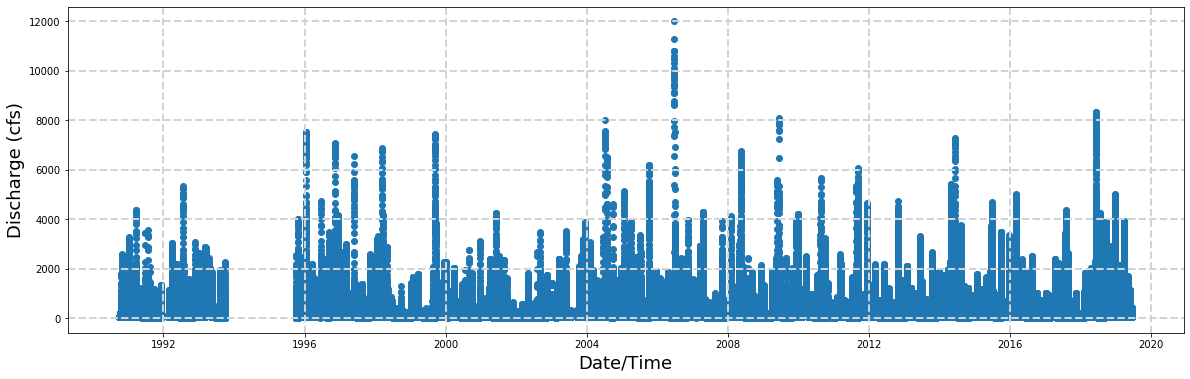

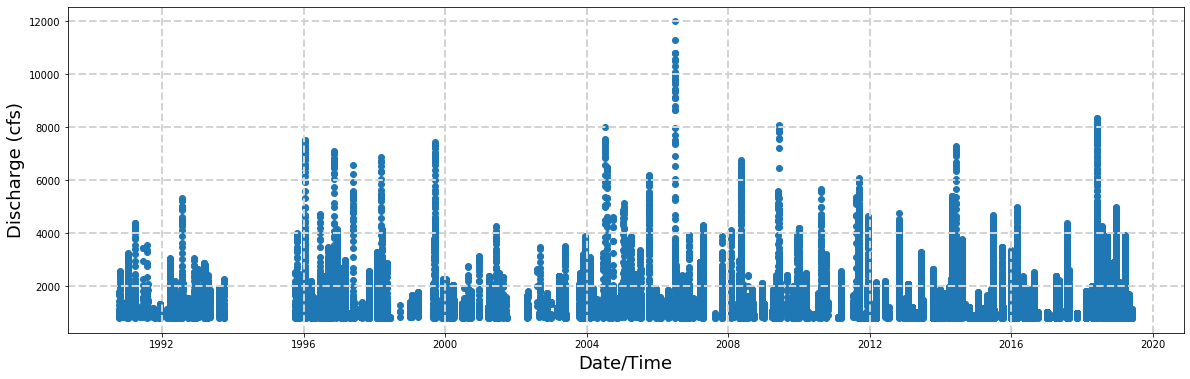

In [9]:
df, dfslice = usgs_to_sliced_df(usgs_values, data_threshold)

plot_scatter(df['dateTime'], y = df['flow'])

plot_scatter(dfslice['dateTime'], y = dfslice['flow'])

##### Transfer the sliced dataframe into a dictionary and plot the hydrographs:

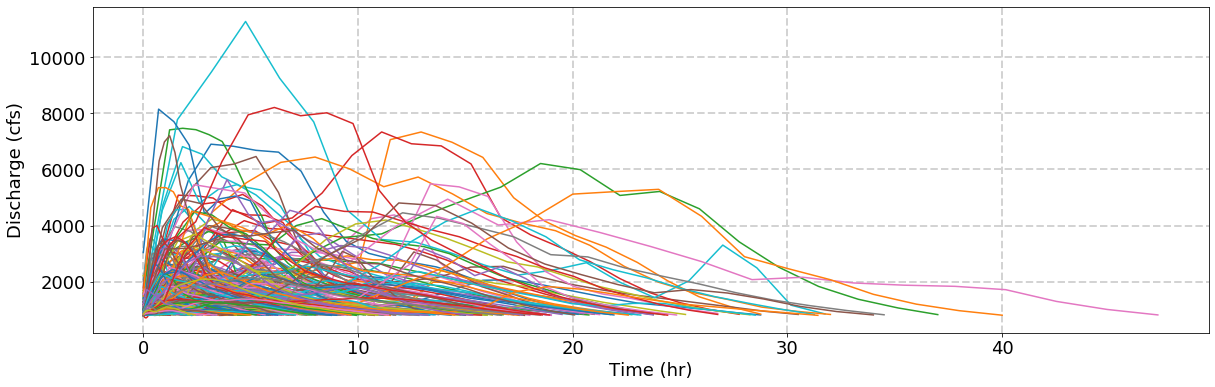

In [10]:
events = events_dic(dfslice)

plot_selected_events(events, dfslice, int_increment, plot_type = "interpolated", legend = False)

#### Load the production list for the specified USGS Gage:

In [11]:
q_mean = pd.read_excel(inputs_dir/'Sampler_Operation_{}.xlsx'.format(USGS_ID), sheet_name='Production Run List', index_col=0)
q_mean.head(2)

AEP   Q_Mean_cfs  Q_Median_cfs        RI    Weight
E0001  0.482369  3971.499423   3971.150886  2.073100  0.035594
E0002  0.448352  4169.403528   4167.124270  2.230391  0.032774

---
## B. Calculate Normalized Mean Hydrographs:
### Group hydrographs by duration and plot:
-  Based on the previous plot and engineering judgment, selected the duration bins to group the hydrographs.

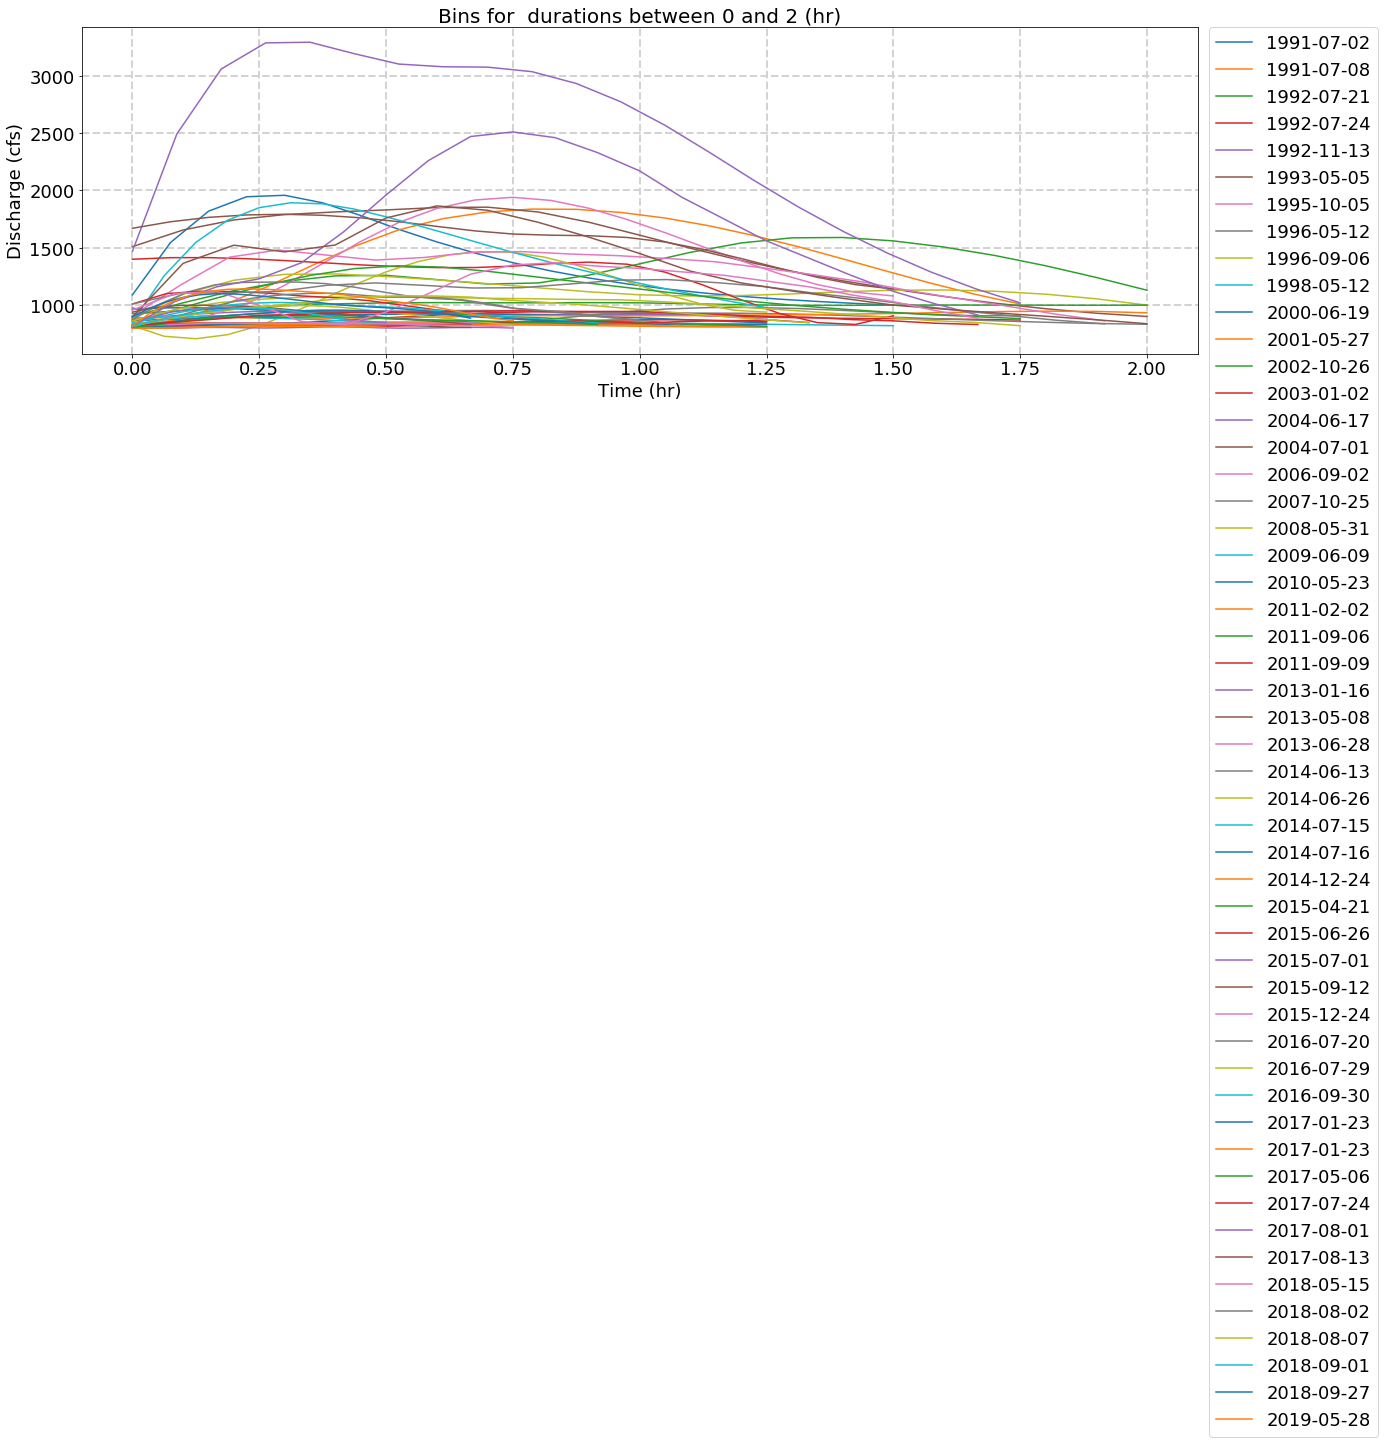

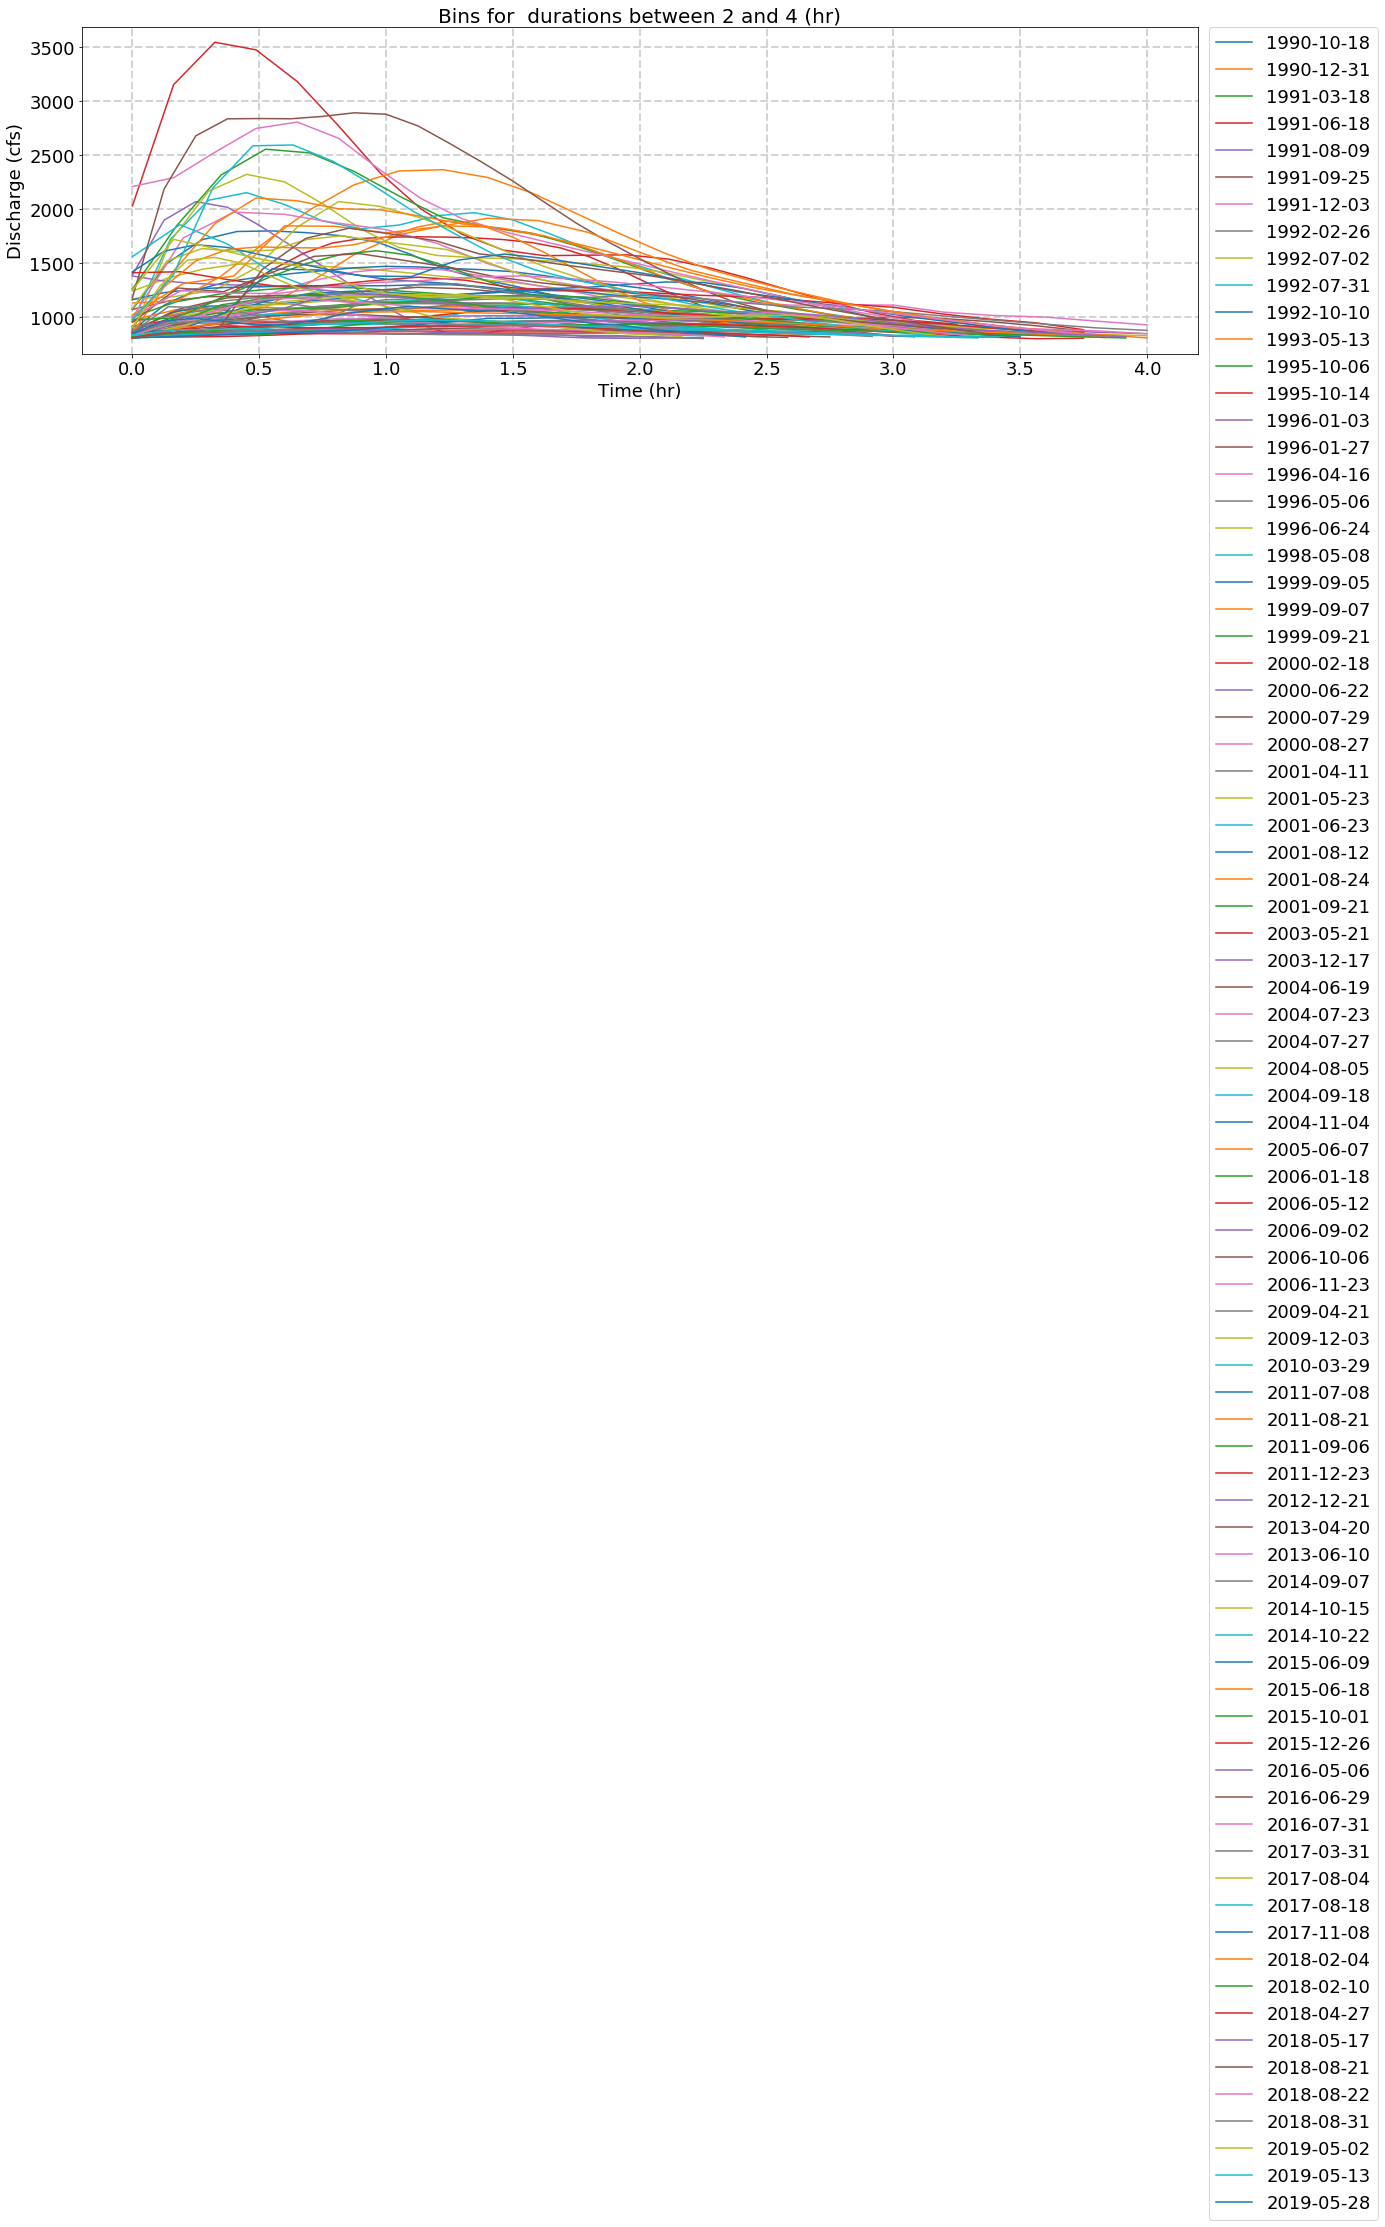

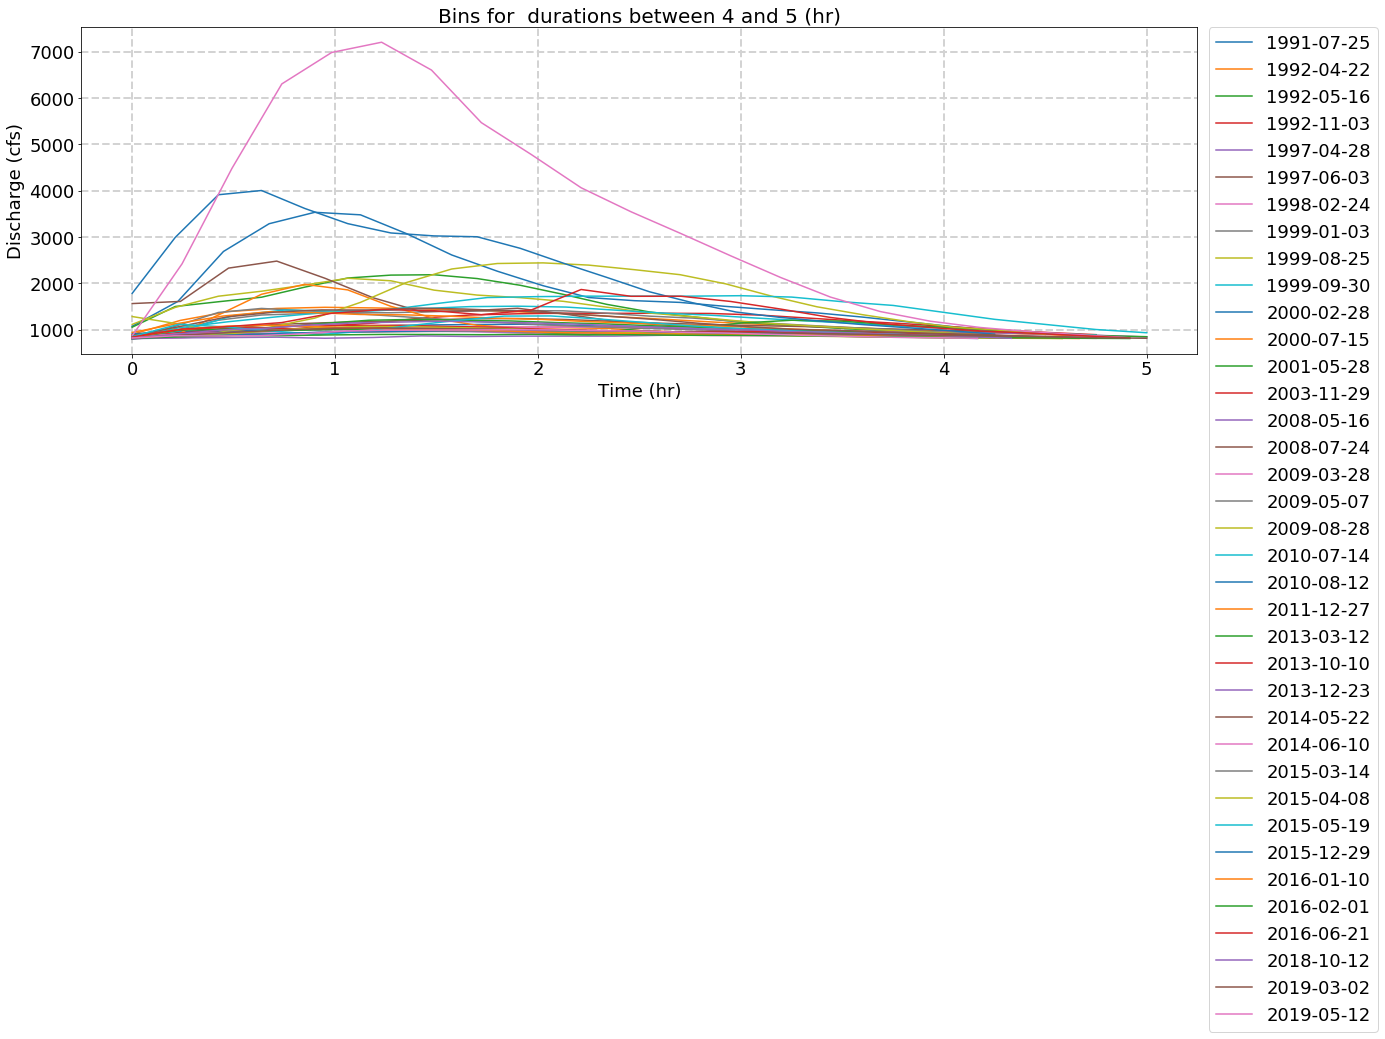

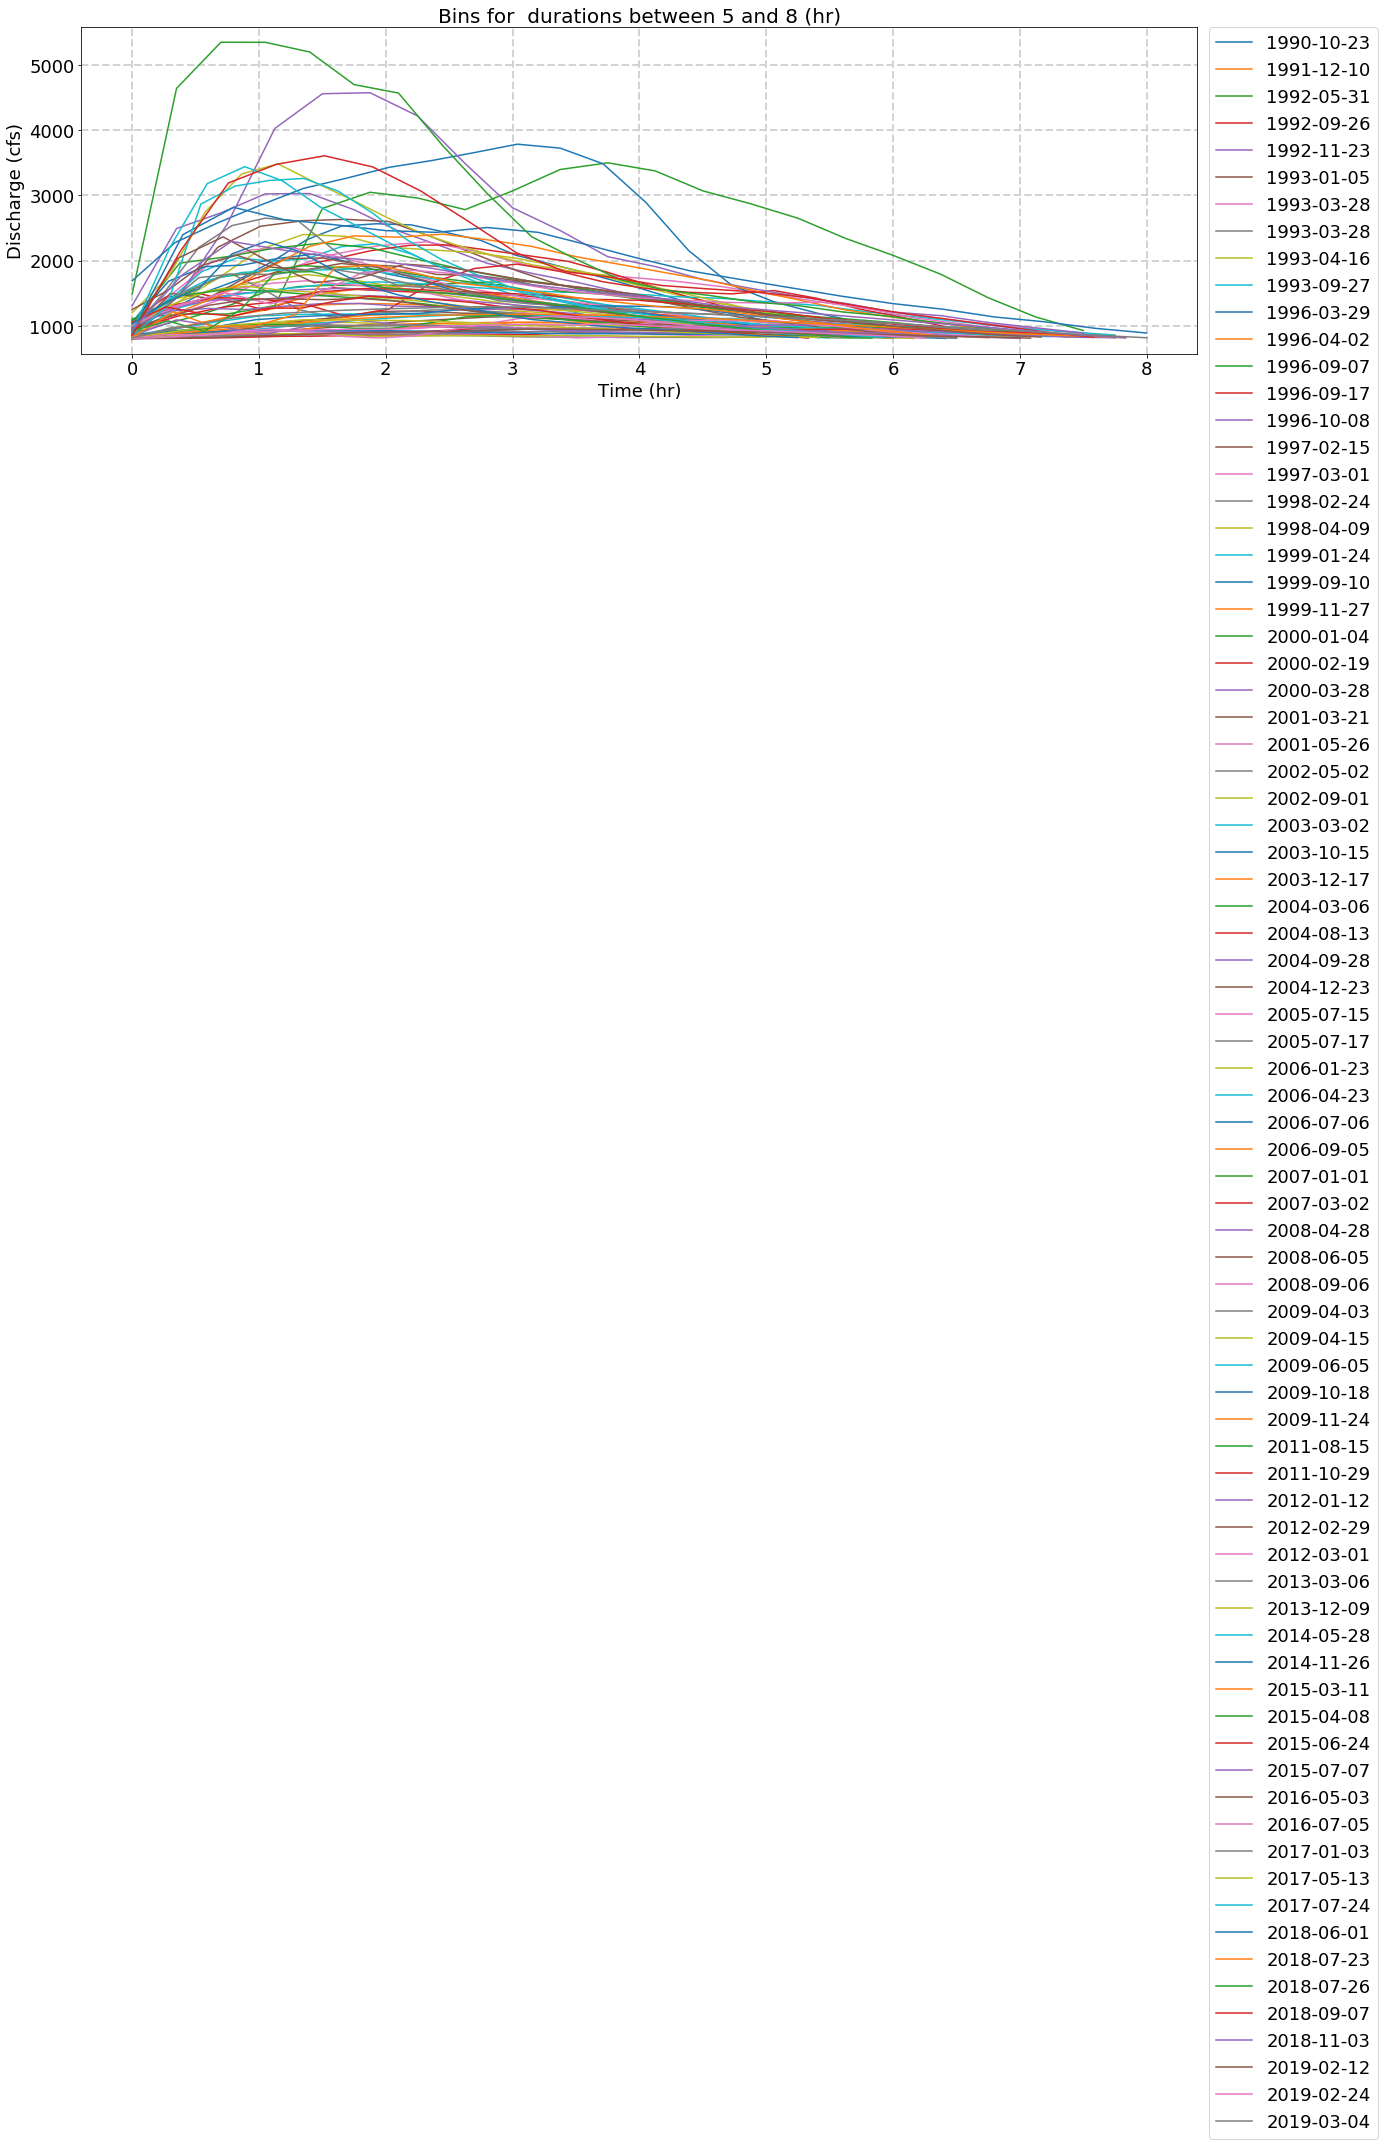

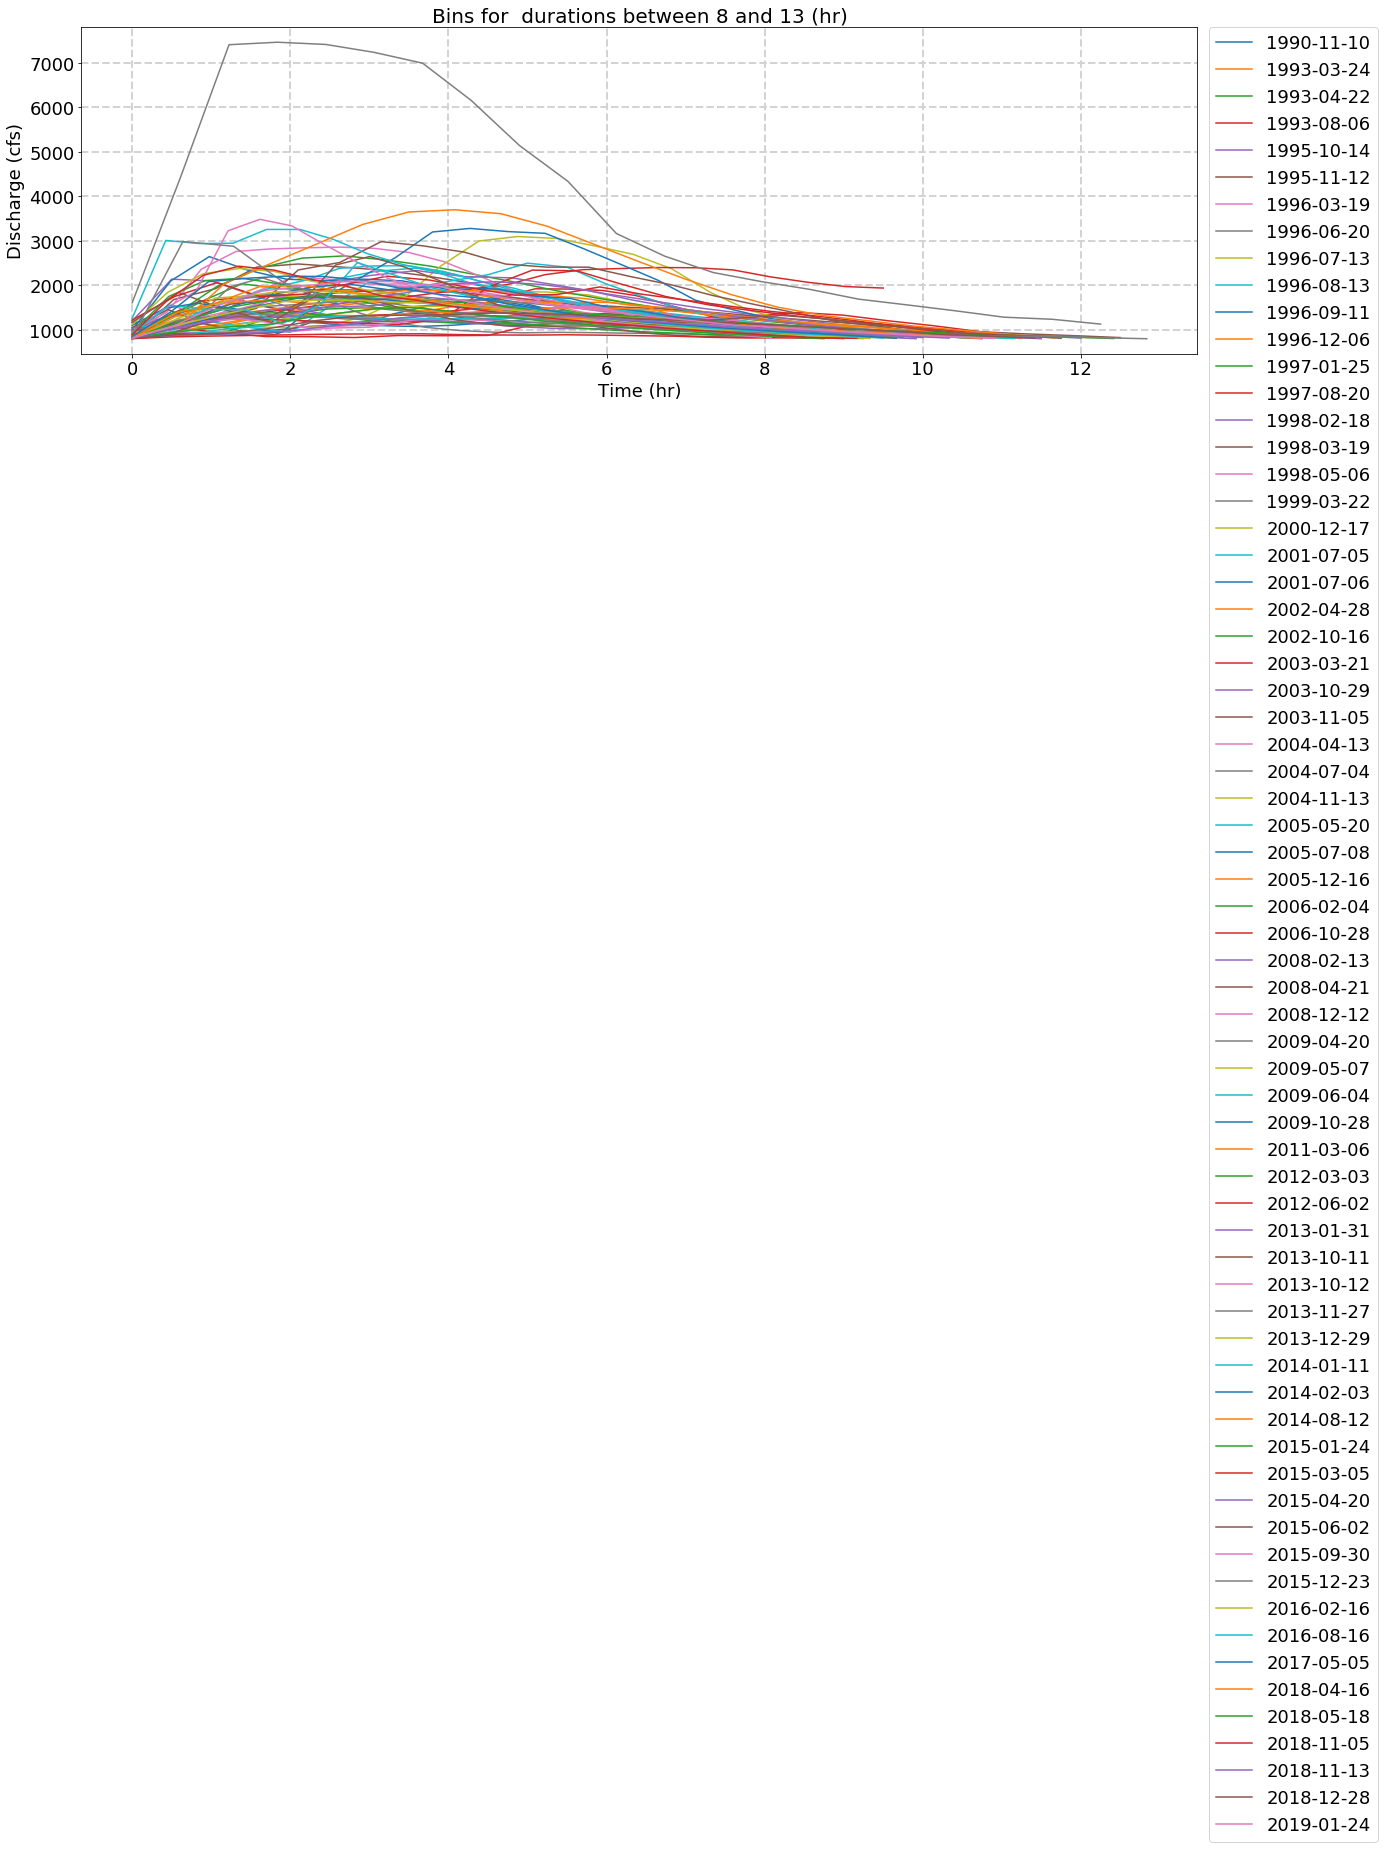

In [12]:
selected_bins = [0, 2, 4, 5, 8, 13] # [hours]; durations

bins_avg_cum_hr = bins_avg_cum_hr_dic(selected_bins, dfslice, events)

hydrograph_group_plot(selected_bins, dfslice, events, bins_avg_cum_hr, int_increment, 
                      "interpolated", data_threshold, legend = True, generate_m_h = False)    

#### Specify the events to exclude, calculate the normalized mean hydrographs, and plot:

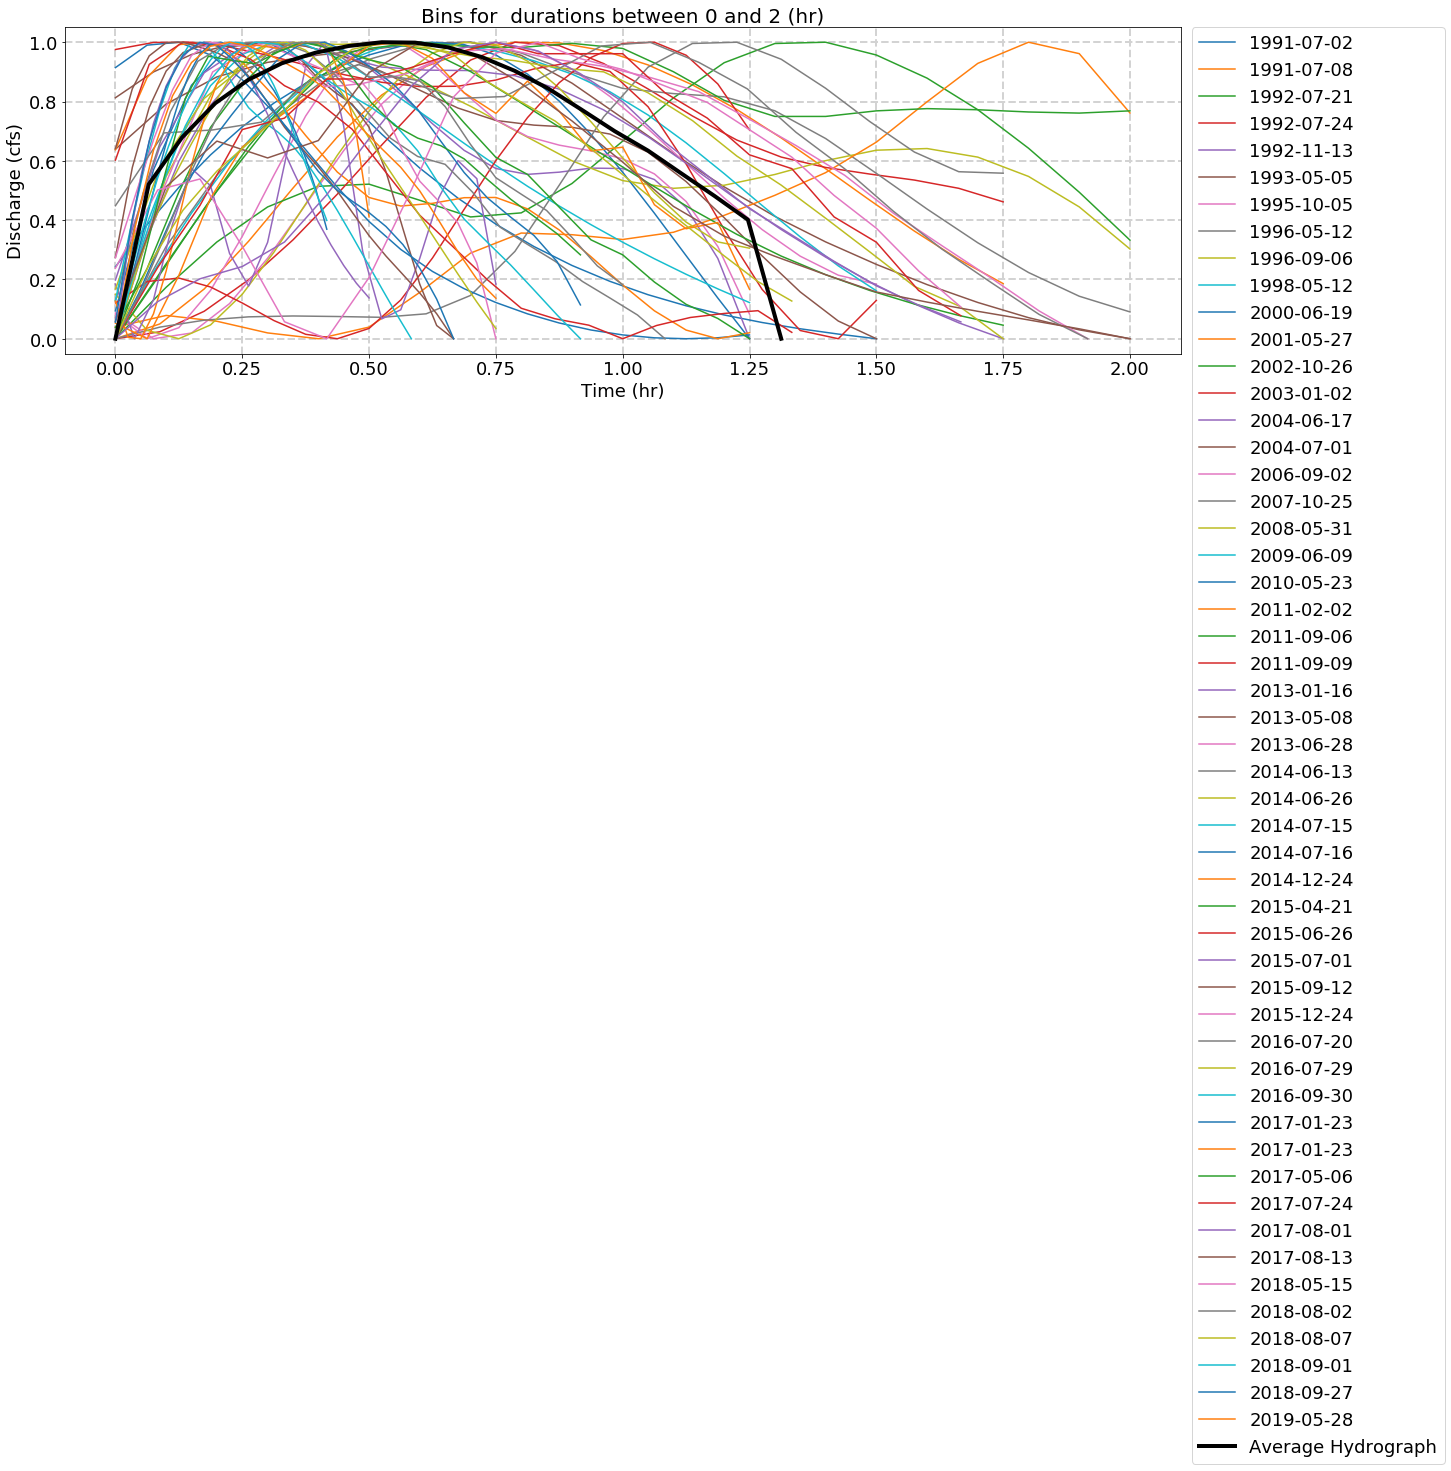

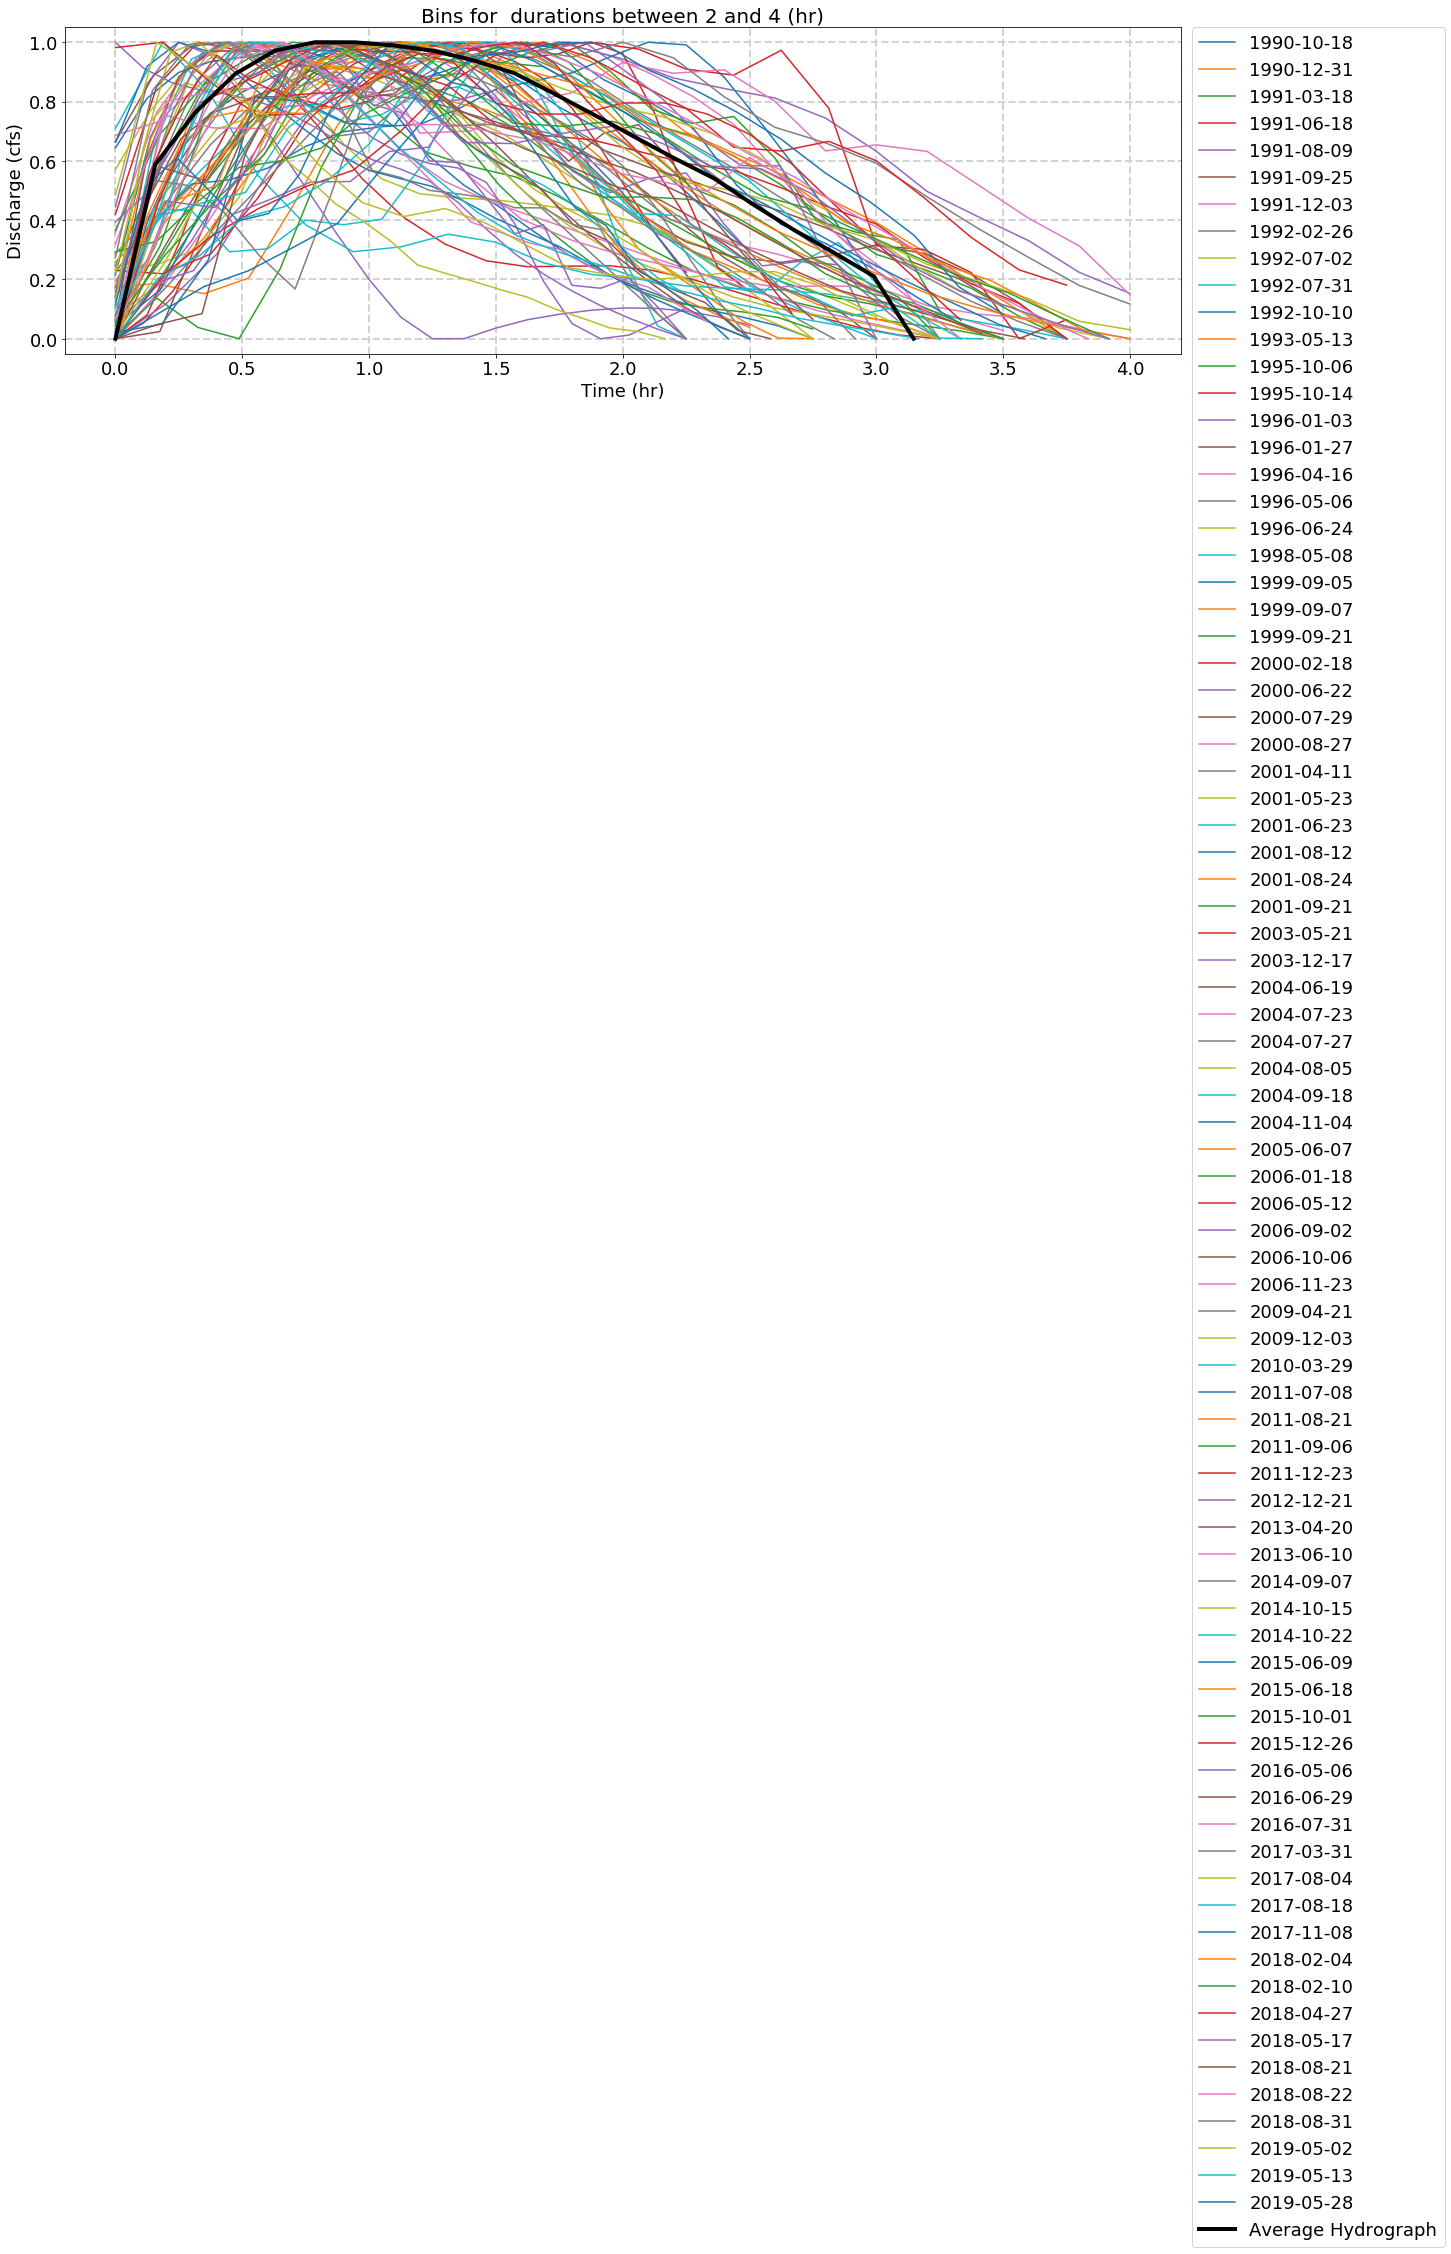

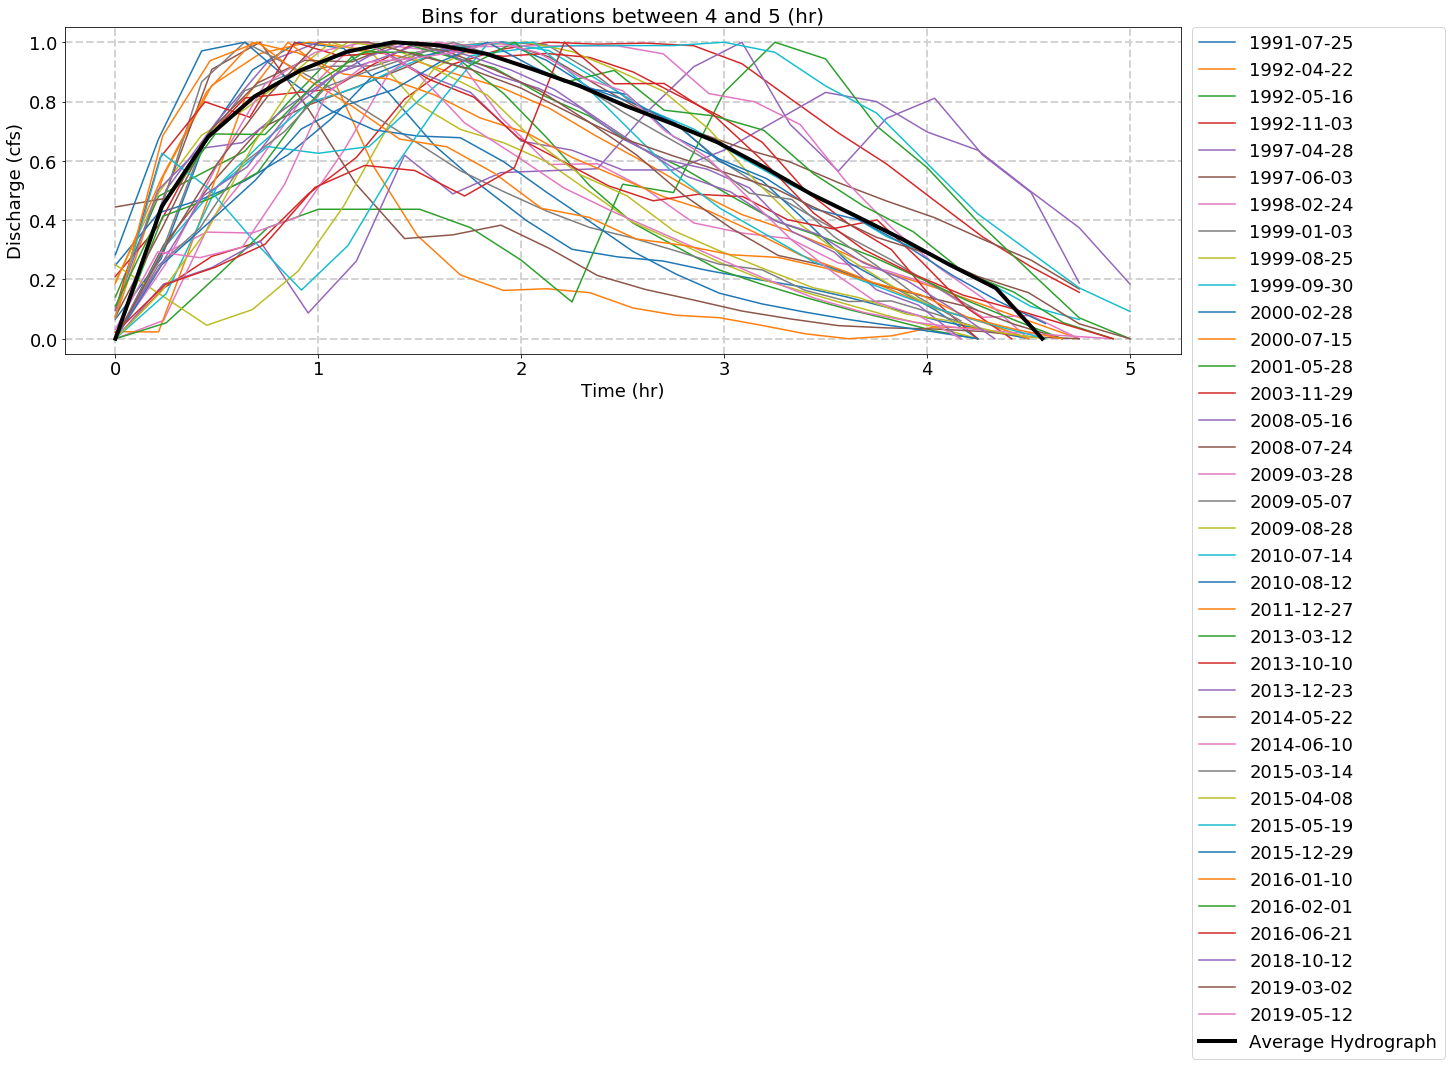

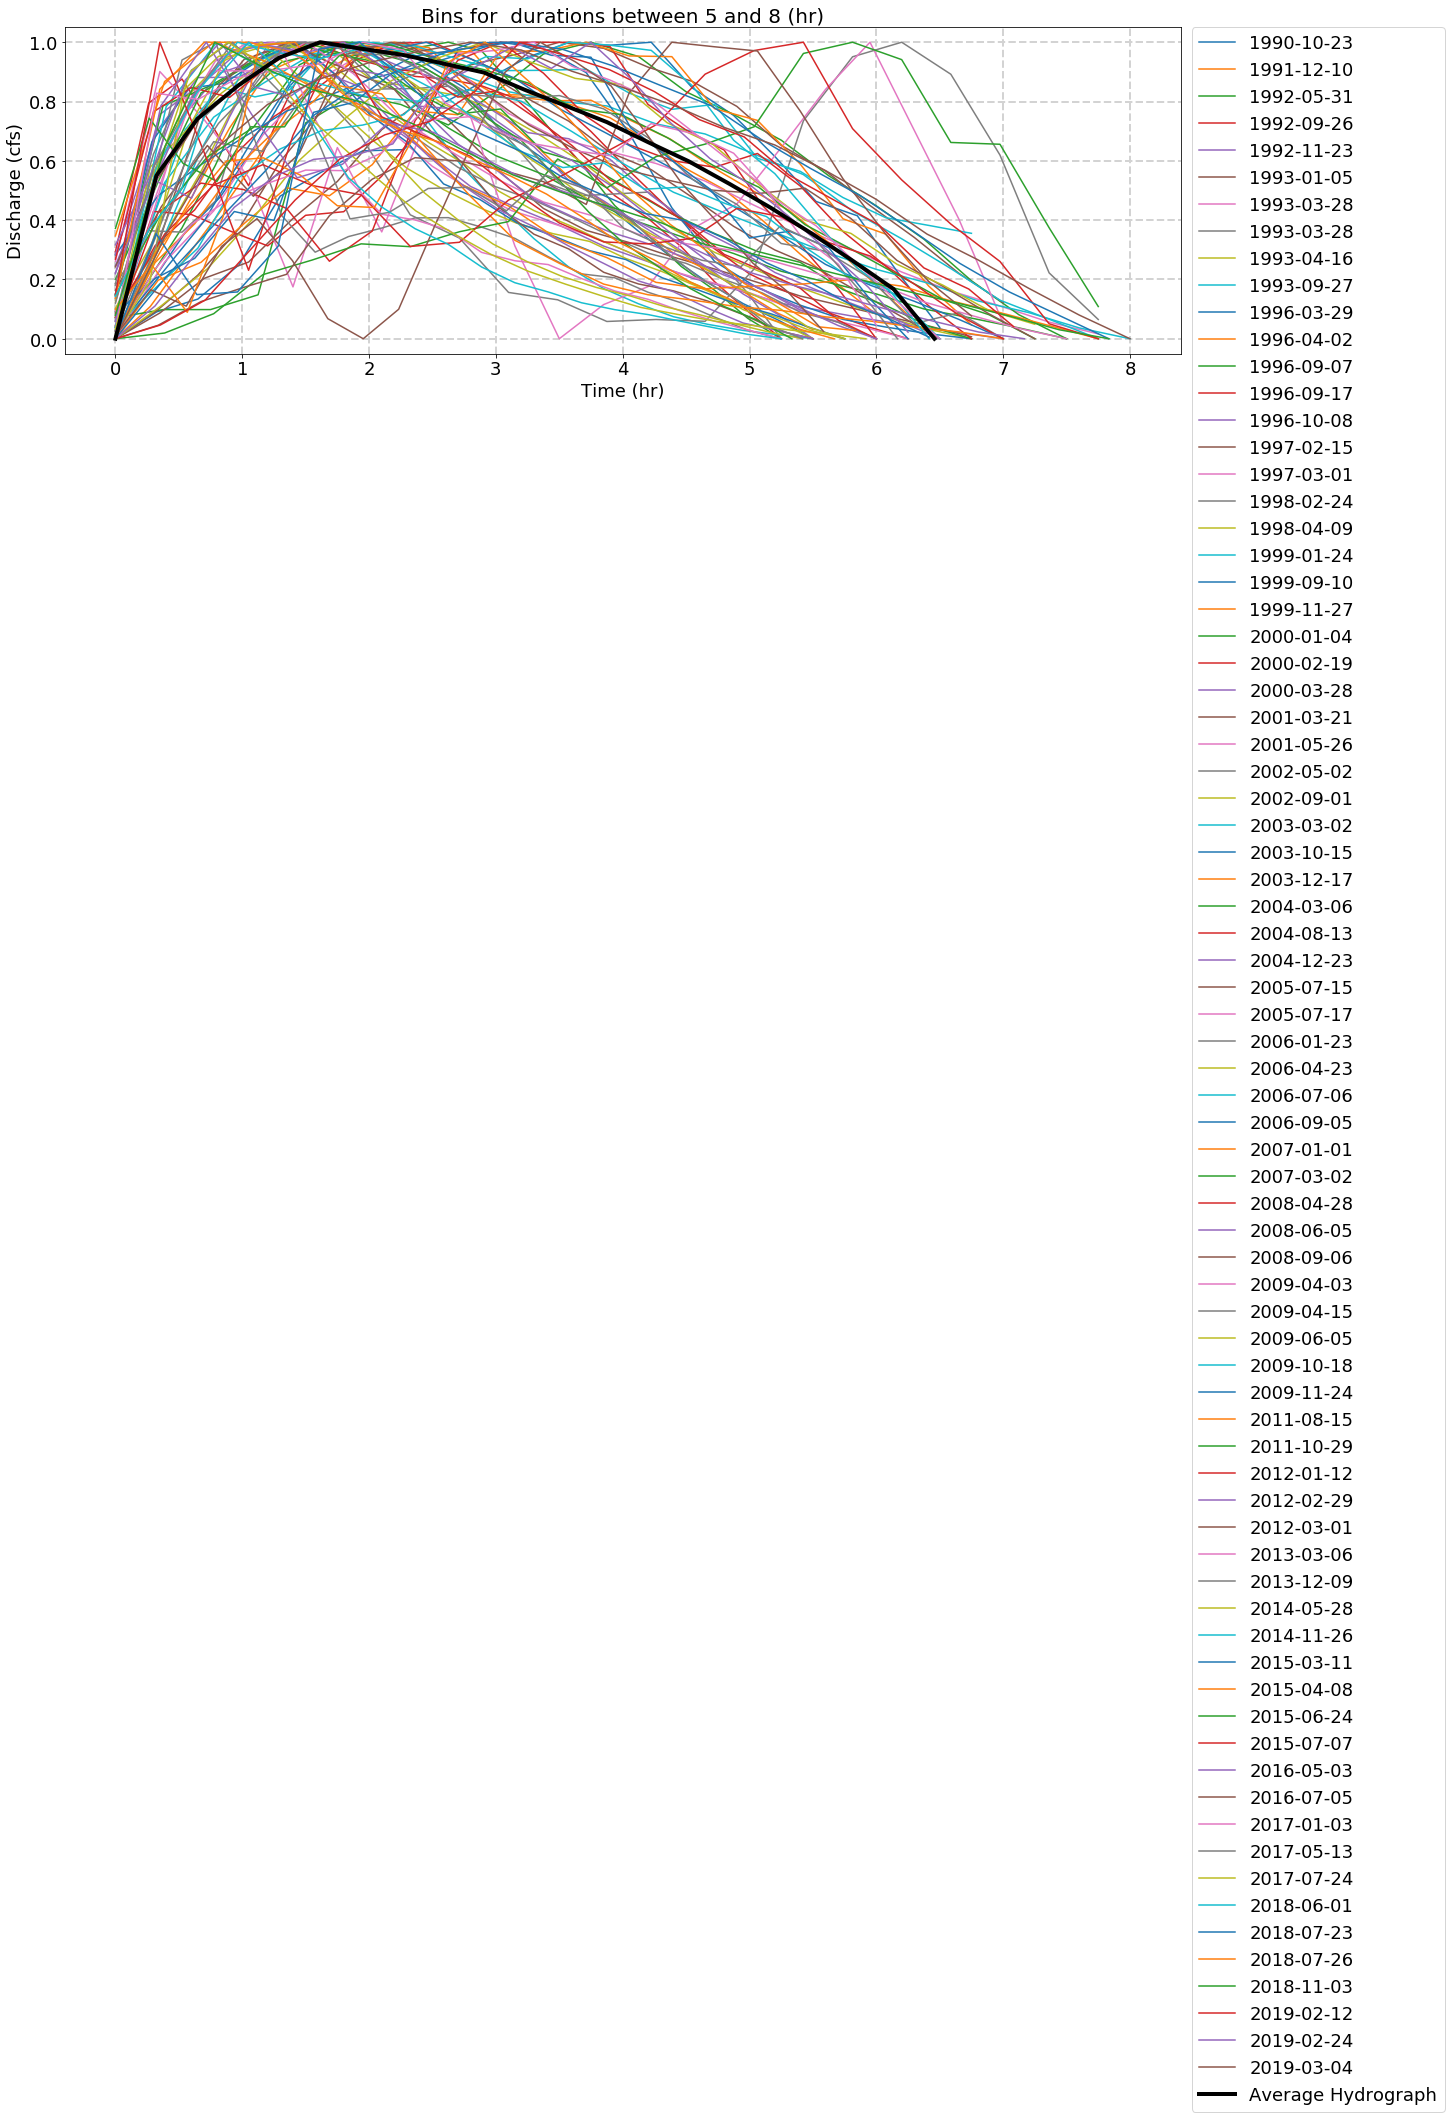

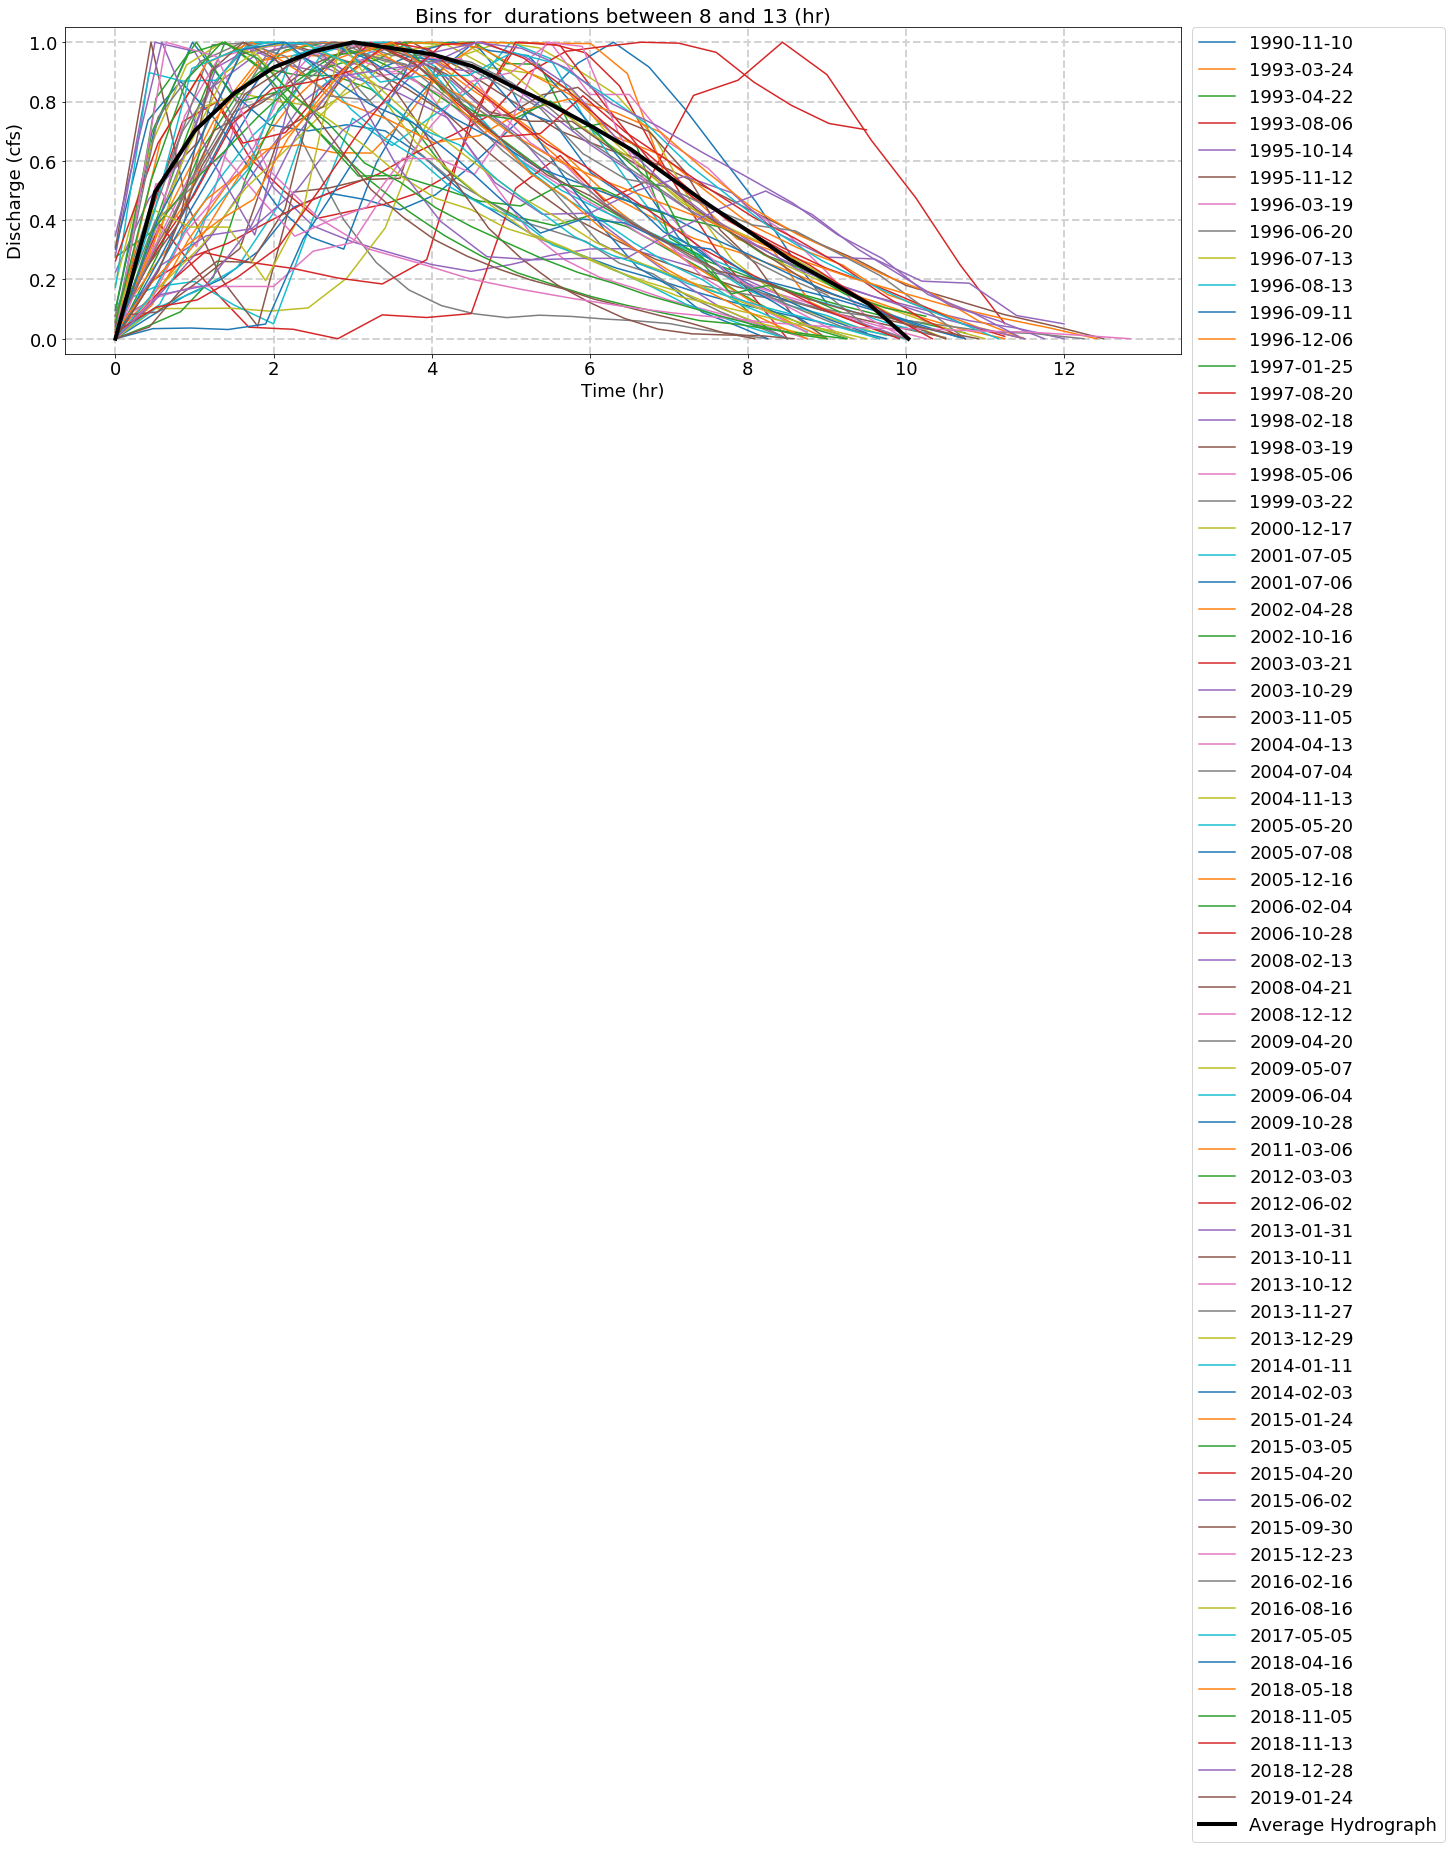

In [13]:
excluded_dates =["2018-09-07", "2019-03-21", "2001-06-07", "2018-09-18",  "2010-08-18", "2009-06-11", 
                 "1996-11-08", "1997-05-26",  "2011-09-08", "2014-04-30", "2008-05-12", "2005-03-23",  
                 "2015-06-27", "2018-06-03", "2005-10-08", "1999-09-16",  "2006-11-16", "2015-06-21",  
                 "2014-08-12", "2004-09-28", "1995-10-21", "2009-12-09", "2005-04-02", "2008-02-01",  
                 "2009-05-26", "2012-10-30", "2006-06-26", "2011-08-28"]

bins_avg_cum_hr = bins_avg_cum_hr_dic(selected_bins, dfslice, events, excluded_dates)

hydrograph_group_plot(selected_bins, dfslice, events, bins_avg_cum_hr, int_increment, 
                      "interpolated_normalized", data_threshold, excluded_dates, legend = True, generate_m_h = True)

### Select the peak that represents each bin:
- Use engineering judgment and the previous plots to decide which flow peaks represent each group.

In [14]:
selected_peaks = {2:4000, 4:4500, 5:5500, 8:6000,  13:q_mean.Q_Mean_cfs.max()}
q_mean.Q_Mean_cfs.max()

32457.19688126289

---
## C) Check the Normalized Mean Hydrographs and Save:
### Calculate a hydrograph for each event within the production list:

In [15]:
bin_return_pd, mean_hydrograph_x, mean_hydrograph_y, flow_df_normailzed  = save_plot_preprocessing(data_threshold, selected_bins, selected_peaks, dfslice, q_mean, bins_avg_cum_hr, events, int_increment, excluded_dates)

### Save either:
#### the normalized mean hydrographs for joint probability analysis:

In [16]:
if not export_forcing:
    normhydro = normhydro_dic(dfslice, events, selected_peaks, bins_avg_cum_hr, selected_bins, excluded_dates, data_threshold, int_increment)
    
    plot_final_hydrographs(bin_return_pd, mean_hydrograph_x, mean_hydrograph_y, legend=True)
    
    with open(inputs_dir/'{0}_{1}_normhydro_{2}.json'.format(Project_Area, Fluvial_Model, BCN), 'w') as f:
        json.dump(normhydro, f)

#### or the final fluvial forcing and weights:

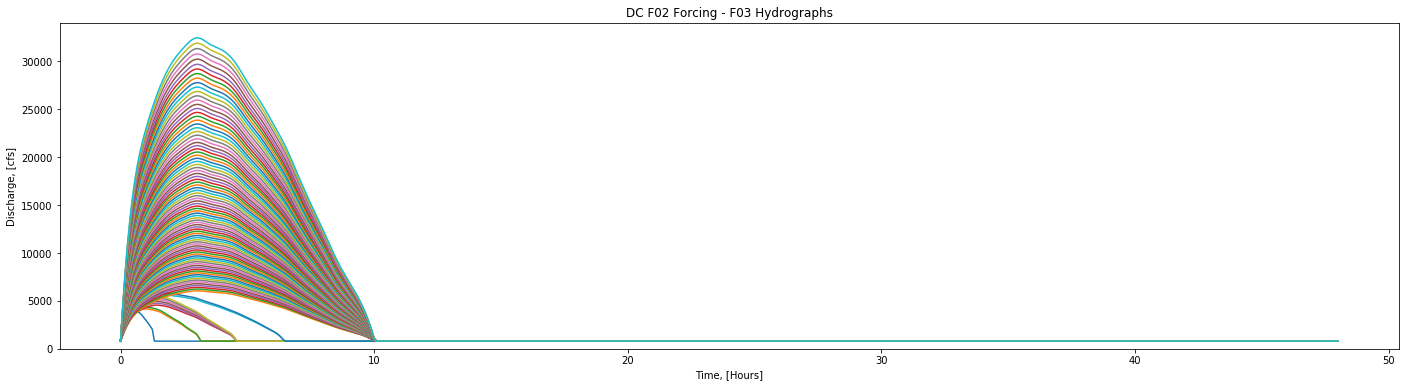

In [17]:
if export_forcing:
    ff_dic = build_fluvial_dict(run_dur, tstep, idx_ord, fluvial_BC_units, verbose = False)
    
    ff_dic = append_norm_hydros(ff_dic, mean_hydrograph_x, mean_hydrograph_y, q_mean, data_threshold, BCN)
    
    plot_normalized_uniform_hydro(ff_dic, Project_Area, Fluvial_Model)
    
    with open(forcing_dir/'{0}_{1}_{2}.json'.format(Project_Area, Fluvial_Model, Domain), 'w') as f:
        json.dump(ff_dic, f)    
        
    weights_dic  = build_fluvial_weights_dic(Domain, q_mean)

    with open(outputs_dir/'{0}_{1}_{2}_Weights.json'.format(Project_Area, Fluvial_Model, Domain), 'w') as f:
        json.dump(ff_dic, f) 

---
## End